In [1]:
%matplotlib inline
import scipy as sp, numpy as np
from scipy.optimize import least_squares
from scipy.stats import ttest_ind, zscore
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

# Load Data


Get X-Data

In [2]:
# Import Data (missing data filled with zeros)
X0 = sp.io.loadmat('X48_0T.mat')['X_data_0T'] # load raw gene data with 0 for missing values

In [3]:
# Option to fill missing data with averages
def Average_Genes(X):
    # Return X with missing values averaged across columns
    X_avg = copy.deepcopy(X)
    num_col = len(X[0, :])
    num_row = len(X[:, 0])
    for col in range(num_col): # columns
        Num_NonZero = 0
        for row in range(num_row): # rows
            if X[row, col] == 0:
                Num_NonZero = Num_NonZero + 1
        if Num_NonZero != 25: # unless row is completely empty (full of 0's)
            Row_Avg = np.mean(X[:,col])*25/(25-Num_NonZero)

            for row in range(num_row): # rows
                if X[row, col] == 0:
                    X_avg[row, col] = Row_Avg;
    return X_avg

X_avg = Average_Genes(X0); # build averaged dataset

In [4]:
# Remove non-gene extraneous experiment data rows
X_avg = X_avg[:, 0:41000]
X0 = X0[:, 0:41000]

Get Y-Data

In [5]:
# Load Y data
Y = sp.io.loadmat('Y48_T.mat')['Y_data_T']

In [6]:
# Split Y Data
Time48 = Y[:, 0] # measurement time (all 48 hr)
Dose48 = Y[:,1] # radiation exposure in Gray
Patients48 = Y[:, 2]; # patient number

Get Gene List

In [7]:
t = time.time()

Genes = pd.read_excel('BE188_Data.xlsx', sheet_name='Genes')
Genes_T = np.transpose(Genes)

elapsed = time.time() - t
print('%f seconds elapsed' %elapsed)

20.721649 seconds elapsed


In [8]:
# Get Ensembl IDs (from Ensembl Biomart)
t = time.time()

Ensembl = pd.read_excel('Ensembl_IDs1.xlsx', sheet_name='Sheet1')
# print(Ensembl)
elapsed = time.time() - t
print('%f seconds elapsed' %elapsed)

30.790428 seconds elapsed


# Percent Variance Explained

Percent Variance

In [9]:
def Normalize(X, Y):
    # Normalize data
    zero_column = np.zeros(25)
    Xnorm = np.zeros((len(X[:,0]), len(X[0,:])))
    for col in range(len(X[0,:])):
        X_list = X[:,col].tolist() # to use the count function
        if np.sum(X[:,col]) != 0 and len(X_list) != X_list.count(X_list[0]): # to exclude rows with only 1 unique entry
            Xnorm[:,col] = zscore(X[:,col])  # normalize the X data . This zscores the genes
    Ynorm = zscore(Y)  # normalize the Y data
    return Xnorm, Ynorm

In [10]:
def Plt_Variance(X, Y, num_components, title = 'Variance Explained', returnVariance = False):
    Xnorm, Ynorm = Normalize(X, Y)
    variance_array = np.zeros(num_components) # calculate variance with different numbers of PLSR
    for i in range(1,num_components+1):
        plsr = PLSRegression(n_components = i) # go for 10
        plsr.fit(Xnorm, Ynorm)
        variance_array[i-1] = 100*plsr.score(Xnorm,Ynorm)
    plt.scatter(range(1,num_components+1),variance_array, color = 'k')
    plt.title(title)
    plt.xlabel("Num Principal Components")
    plt.ylabel("Percent Variance Explained")
    plt.show()
    if returnVariance is True:
        return variance_array

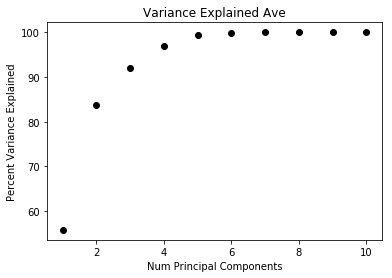

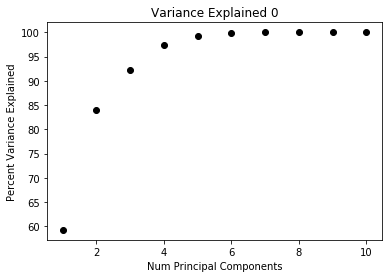

In [11]:
Variance_avg = Plt_Variance(X_avg, Dose48, 10, returnVariance = True, title = 'Variance Explained Ave');
Variance_X0 = Plt_Variance(X0, Dose48, 10, returnVariance = True, title = 'Variance Explained 0');

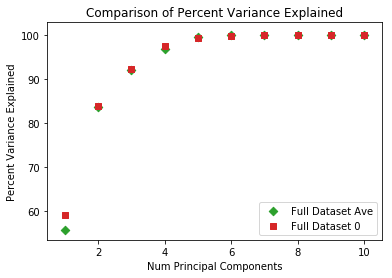

In [12]:
# Compare averages vs zeros for missing data
num_components = 10
plt.scatter(range(1,num_components+1),Variance_avg, color = 'tab:green', marker = 'D', label = 'Full Dataset Ave')
plt.scatter(range(1,num_components+1),Variance_X0, color = 'tab:red', s = 26, marker = 's', label = 'Full Dataset 0')
plt.legend()
plt.title('Comparison of Percent Variance Explained')
plt.xlabel("Num Principal Components")
plt.ylabel("Percent Variance Explained");
#plt.savefig('PercVariComp_AvgVs0.png', bbox_inches = 'tight')

# Scores and Loadings

Plot Scores

In [13]:
# Setup PLSR for scores
def Plt_Scores(X, Y, xbound = None, ybound = None, save = False, saveas = 'Scores.png'):
    # input unnormalized data
    
    Xnorm, Ynorm = Normalize(X, Y)
    plsrScore = PLSRegression(n_components = 2)
    plsrScore.fit(Xnorm,Ynorm)
    scores = plsrScore.x_scores_ 

    # Plot scores
    Doses = [0, 0.5, 2, 5, 8]
    iDoses = ['i0','i0_5', 'i2', 'i5', 'i8']
    colors = ['tab:blue', 'tab:green', 'gold', 'tab:orange', 'tab:red']
    
    fig, axs = plt.subplots(figsize = (7,7))
    for i, dose in enumerate(Doses):
        iDoses[i] = np.where(Dose48 == Doses[i])[0] # Get indices of each dosage
        plt.scatter(scores[iDoses[i],0],scores[iDoses[i],1], c = colors[i], label = Doses[i]) # plot scores by radiation level

    # Format plot
    plt.legend(title = 'Gray', loc = 'lower left')
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    #plt.title('Scores')
    plt.xlim(xbound)
    plt.ylim(ybound)
    #axs.set_aspect('equal')
    if save is True:
        plt.savefig(saveas, bbox_inches = 'tight')

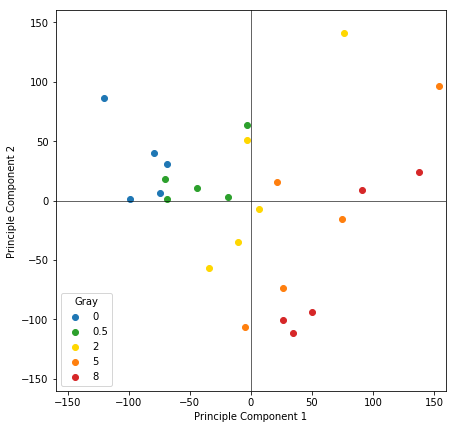

In [14]:
Plt_Scores(X0, Dose48, xbound = (-160, 160), ybound = (-160, 160), save = False)

Plot Loadings

In [15]:
def Plt_Loadings(X, Y, xbound = None, ybound = None, save = False, saveas = 'Loadings.png', size = 0.05):
    # input unnormalized data
    
    Xnorm, Ynorm = Normalize(X, Y)
    plsrScore = PLSRegression(n_components = 2)
    plsrScore.fit(Xnorm,Ynorm)
    loadings = plsrScore.x_loadings_ 
    
    # Plot loadings
    marksize = size
    fig, axs = plt.subplots(figsize = (7,7))
    plt.scatter(loadings[:,0],loadings[:,1], s = marksize, color = 'k')
    #plt.scatter(loadings[Sig_indices7, 0], loadings[Sig_indices7, 1], s = marksize+8, color = 'r') # overlay points with 7 or more significant t-test comparisons
    #plt.scatter(loadings[Sig_indices8, 0], loadings[Sig_indices8, 1], s = marksize+4, color = 'g') # overlay points with 8 or more significant t-test comparisons
    #plt.scatter(loadings[Sig_indices3, 0], loadings[Sig_indices3, 1], s = marksize, color = 'tab:orange') # overlay points with 3 or fewer significant t-test comparisons

    
    # Format plot
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    #plt.title('Loadings')
    plt.xlim(xbound)
    plt.ylim(ybound)
    #axs.set_aspect('equal')
    if save is True:
        plt.savefig(saveas, bbox_inches = 'tight')

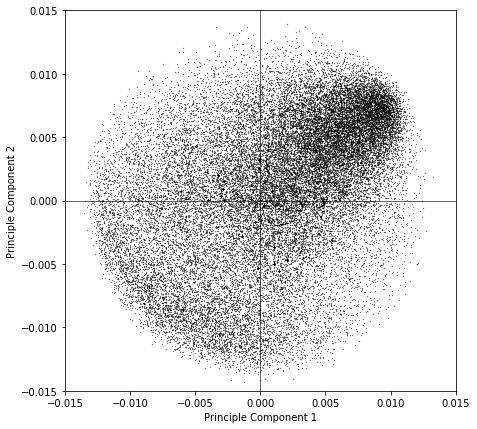

In [16]:
# Load indices of significant/non-significant points to overlay on loadings
Sig_indices7 = np.load('iMin7Sig.npy')
Sig_indices8 = np.load('iMin8Sig.npy')
Sig_indices3 = np.load('iMax3Sig.npy')

# Plot loadings
Plt_Loadings(X0, Dose48, xbound = (-0.015, 0.015), ybound = (-0.015, 0.015), save = False)

# Cross Validation

In [17]:
def CV(Y, Average = False, X = X0, num_components = 8, reduce = False, diff_thresh = 8):
    loo = LeaveOneOut()
    StanScale = StandardScaler()

    # Get Y predicted for variable number of components
    Ypredicted = np.zeros((len(X[:,0]),num_components))
    R2_array = np.zeros(num_components)
    n = 0
    for c in range(1,num_components+1):
        plsr = PLSRegression(n_components=c)
        for train_index, test_index in loo.split(X):
            Xtrain = X[train_index]
            Ytrain = Y[train_index]
            X2 = X
            
            if Average is True: # average X
                Xtrain = Average_Genes(Xtrain)
            if reduce is True: # reduce dataset based on genes differentially expressed
                Sig_indices = T_test_reduce(Xtrain, Ytrain, p_thresh = 0.05, diff_thresh = diff_thresh)
                Xtrain = Xtrain[:, Sig_indices]
                X2 = X[:, Sig_indices]
                
            Xtrain_norm = StanScale.fit_transform(Xtrain)
            Ytrain_norm = zscore(Ytrain)
            plsr.fit(Xtrain_norm,Ytrain_norm)
            Ypredicted[n,c-1] = plsr.predict(StanScale.transform(X2[test_index]))
            n += 1
        R2_array[c-1] = r2_score(zscore(Y), Ypredicted[:, c-1])
        n = 0
    return Ypredicted, R2_array

In [18]:
def Plot_Msmnt_vs_Prdct(YpredictLOO, Y, components = 3, xy_endpts = (0, 7)):
    # must pass in zscored Y and Y predicted
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(8/2.49*(YpredictLOO[:, components-1]+1.01), 8/2.49*(Y+1.01), color = 'k')
    plt.xlabel('Predicted Dosage (Gray)')
    plt.ylabel('Measured Dosage (Gray)')
    plt.title(f'{components} Componenet Cross Validation')
    plt.plot(xy_endpts, xy_endpts, linestyle = '--', color = 'k', linewidth = 0.8);

In [19]:
t = time.time() # add tic toc to diagnose how long this code takes

Ypredicted_Full, R2_array_Full = CV(Dose48, Average = False, num_components = 8) # Average = True takes a few minutes
#np.save('Ypredicted_Full_Ave.npy', Ypredicted_Full)
#np.save('R2_array_Full_Ave.npy', R2_array_Full)

elapsed = time.time() - t
print('%f seconds elapsed' %elapsed)

22.158276 seconds elapsed


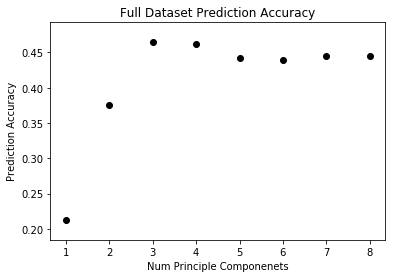

In [20]:
# Plot full dataset prediction accuracy
plt.scatter(range(1,9), R2_array_Full, color = 'k')
plt.title('Full Dataset Prediction Accuracy')
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');
#plt.savefig('Full_Data_R2CV', bbox_inches = 'tight')

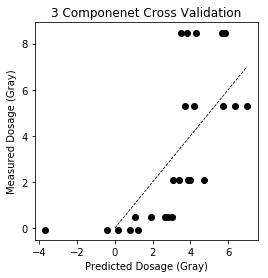

In [21]:
# Plot full dataset measrued vs predicted
Plot_Msmnt_vs_Prdct(Ypredicted_Full, zscore(Dose48), components = 3)
#plt.savefig('Full_DataMsrvsPrd', bbox_inches = 'tight')

# Reduce Data

T-Test Data to identify significant genes

In [22]:
def T_test_reduce(X, Y, p_thresh = 0.05, diff_thresh = 8, comparison = '<='):
    # Returns indices of important genes
    
    # Get indices of each dose
    Doses = [0, 0.5, 2, 5, 8]
    iDoses = ['i0','i0_5', 'i2', 'i5', 'i8']
    for i, dose in enumerate(Doses):
        iDoses[i] = np.where(Y == Doses[i])[0] # Get indices of each dosage

    # Compare expression of each gene across doses
    sig_cols = np.zeros(len(X[0,:]))
    count_sig_cols = 0

    for col in range(len(X[0,:])): # go through all columns

        count_sig_p = 0

        # Identify significant comparisons
        for start in range(len(Doses)-1):
            for num in range(start+1, len(Doses)):
                dist1 = X[iDoses[start], col]
                dist2 = X[iDoses[num], col]
                p_value = ttest_ind(dist1, dist2)[1]
                if p_value < p_thresh:
                    count_sig_p += 1
                    
        # Tally significance
        if comparison == '>=':
            if count_sig_p >= diff_thresh: # if gene is differentially expressed across all but 10-'diff_thresh' radiation levels
                sig_cols[count_sig_cols] = col
                count_sig_cols += 1
        elif comparison == '<=':
            if count_sig_p <= diff_thresh: # if gene is differentially expressed across 'diff_thresh' or fewer radiation levels
                sig_cols[count_sig_cols] = col
                count_sig_cols += 1

    sig_cols_out = np.trim_zeros(sig_cols, trim = 'b').astype(int) # remove trailing zeros
    return sig_cols_out

Remove non-significant genes

In [23]:
# Remove genes with 0% probability of becoming significant
# Changing one radiation level can change at most 4 comparisons
# Fewer than 4 significant comparisons could never become significant if the threshold for being considered 'important' >= 8

t = time.time() # add tic toc to diagnose how long this code takes

Sig_indices = T_test_reduce(X0, Dose48, p_thresh = 0.05, diff_thresh = 7, comparison = '>=')

elapsed = time.time() - t
print('%f seconds elapsed' %elapsed)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


93.700567 seconds elapsed


In [24]:
# Analyze and save reduced datasets indices
print(np.shape(Sig_indices))
print(Sig_indices)
#np.save('iMin3Sig.npy', Sig_indices)

(143,)
[  114   621   699  1039  1365  1487  1498  1692  1797  2094  2220  2231
  2395  2444  2446  2666  3147  3150  3168  3241  3311  3575  3785  3790
  3984  4040  4062  4185  4203  4557  5188  5759  6252  6444  6445  6571
  6758  6776  7034  7113  7313  7505  7637  7709  8213  8224  8432  8491
  8572  8882  9091  9314  9354  9394  9498  9568 10295 10932 11019 11062
 11184 11197 11635 12439 12540 12690 12965 13035 13329 13955 14436 14526
 14842 14850 14922 15004 15008 15038 15563 15818 15969 16053 16142 16264
 16400 16404 16535 17044 17102 17201 17231 17420 17443 17502 18011 18235
 18657 19084 19123 19372 19458 20627 20803 20863 20967 21329 21468 21904
 21932 22415 22552 23795 24130 24429 24533 26257 27031 28267 29895 30317
 30704 30881 31161 31353 32053 32470 32906 33030 33263 33431 33635 33764
 33969 34440 35436 35581 35887 36591 38338 39805 39818 40376 40552]


Assign IDs to significant genes for PANTHER

In [25]:
PANTHER = False # will create 2 new excel files if run with PANTHER = True

# Get subset of significant genes
Sig7 = np.load('iMin7Sig.npy')
SigGenes = Genes_T[Sig7]
SigGenes_T = np.transpose(SigGenes)
if PANTHER is True:
    SigGenes_T.to_excel('SigGenes7Sig.xlsx') # save to excel for easier formatting
# excel file was formatted to give it the same headings as the Ensembl dataframe and resaved as SigGenesFormatted
#print(SigGenes)

In [26]:
# Reload Agilent IDs in same format as Ensembl
SigAgilent = pd.read_excel('SigGenesFormatted.xlsx', sheet_name='7Sig')

# Remove Agilent and Ensembl dataframes
EnsemblVal = Ensembl.values
AgilentVal = SigAgilent.values

# Assign Ensembl IDs to significant Agilent IDs
for iAg in range(len(AgilentVal[:, 2])):
    for iEn in range(len(EnsemblVal[:, 2])):
        if AgilentVal[iAg, 2] == EnsemblVal[iEn, 2]:
            AgilentVal[iAg, 0] = EnsemblVal[iEn, 0]

In [27]:
# Save Ensembl IDs of Significant Genes to enter into PANTHER
SigEnsembl = AgilentVal[:, 0]
if PANTHER is True:
    pd.DataFrame(SigEnsembl).to_csv("SigEnsembl2.csv", header = None, index = None)

Rerun with reduced data

In [28]:
# Load reduced datasets
Sig8 = np.load('iMin8Sig.npy')
print(f'There are {len(Sig8)} genes with 8 or more significant comparisons')
X8sig0 = X0[:, Sig8]

Sig7 = np.load('iMin7Sig.npy')
print(f'There are {len(Sig7)} genes with 7 or more significant comparisons')
X7sig0 = X0[:, Sig7]

Sig4 = np.load('iMin4Sig.npy')
print(f'There are {len(Sig4)} genes with 4 or more significant comparisons')
X4sig0 = X0[:, Sig4]

Sig3 = np.load('iMin3Sig.npy')
print(f'There are {len(Sig3)} genes with 3 or more significant comparisons')
X3sig0 = X0[:, Sig3]

Sig2 = np.load('iMin2Sig.npy')
print(f'There are {len(Sig2)} genes with 2 or more significant comparisons')
X2sig0 = X0[:, Sig2]

Sig1 = np.load('iMin1Sig.npy')
print(f'There are {len(Sig1)} genes with 1 or more significant comparisons')
X1sig0 = X0[:, Sig1]

print(f'There are {len(X0[0,:])} total genes')

There are 67 genes with 8 or more significant comparisons
There are 139 genes with 7 or more significant comparisons
There are 1206 genes with 4 or more significant comparisons
There are 2183 genes with 3 or more significant comparisons
There are 294 genes with 2 or more significant comparisons
There are 7505 genes with 1 or more significant comparisons
There are 41000 total genes


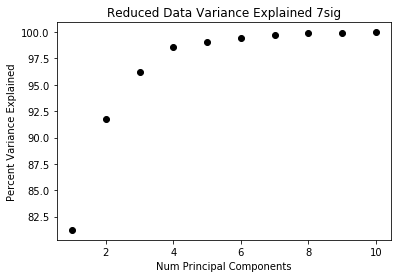

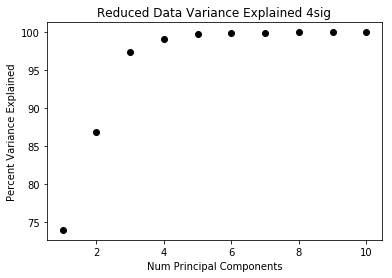

In [29]:
# Plot percent variance explained
#Plt_Variance(X4sig, Dose48, 10, returnVariance = False, title = 'Reduced Data Variance Explained Ave')
Variance_7sig = Plt_Variance(X7sig0, Dose48, 10, returnVariance = True, title = 'Reduced Data Variance Explained 7sig')
Variance_4sig = Plt_Variance(X4sig0, Dose48, 10, returnVariance = True, title = 'Reduced Data Variance Explained 4sig')

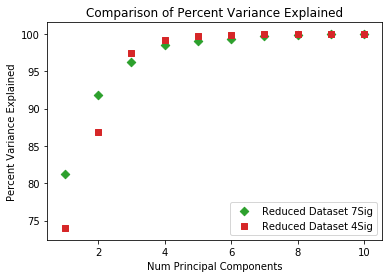

In [30]:
# Plot together
num_components = 10
plt.scatter(range(1,num_components+1),Variance_7sig, color = 'tab:green', marker = 'D', label = 'Reduced Dataset 7Sig')
plt.scatter(range(1,num_components+1),Variance_4sig, color = 'tab:red', s = 26, marker = 's', label = 'Reduced Dataset 4Sig')
plt.legend()
plt.title('Comparison of Percent Variance Explained')
plt.xlabel("Num Principal Components")
plt.ylabel("Percent Variance Explained");

In [31]:
# Running cross validation on a dataset reduced to not include any gene that our t-test within 
# cross validation could not possibly identify as significant
run_reduced_CV = False # depending on inputs, code could take 0.5-2 hrs
if run_reduced_CV is True:
    t = time.time()

    Ypredicted_Red, R2_array_Red = CV(Dose48, Average = False, X = X3sig0, num_components = 8
                                      , reduce = True, diff_thresh = 7)
    #np.save('Ypredicted_Red_X0_1sig.npy', Ypredicted_Red)
    #np.save('R2_array_Red_X0_1sig.npy', R2_array_Red)
    elapsed = time.time() - t
    print('%f seconds elapsed' %elapsed)

Max prediction accuracy: 0.798874


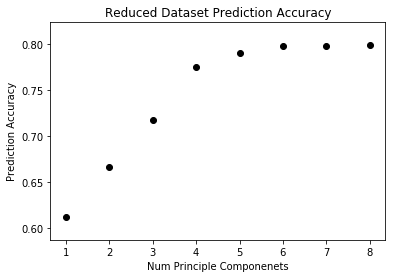

In [32]:
# Plot cross validation R^2
R2_array_Red = np.load('R2_array_Red_X0_7sig.npy')
print('Max prediction accuracy: %f' %max(R2_array_Red))
plt.scatter(range(1,9), R2_array_Red, color = 'k')
plt.title('Reduced Dataset Prediction Accuracy')
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');
#plt.savefig('Reduced_Dataset_Prediciton_Accuracy_T-test_7sig')

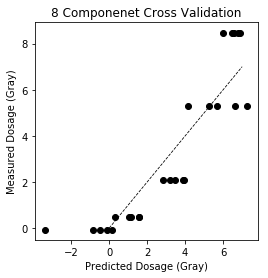

In [33]:
# Plot observation vs prediction
#Ypredicted_Red_8sig = np.load('Ypredicted_Red_X0_8sig.npy')
#Plot_Msmnt_vs_Prdct(Ypredicted_Red_8sig, zscore(Dose48), components = 5)
Ypredicted_Red_7sig = np.load('Ypredicted_Red_X0_7sig.npy')
Plot_Msmnt_vs_Prdct(Ypredicted_Red_7sig, zscore(Dose48), components = 8)
plt.savefig('Reduced_Data_MsrvsPrd_7sig', bbox_inches = 'tight')

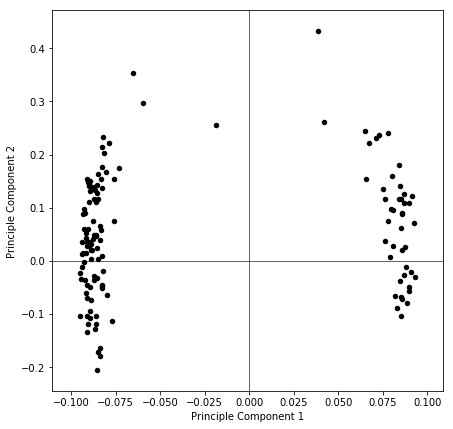

In [34]:
# Plot Loadings
Plt_Loadings(X7sig0, Dose48, size = 20, save = False, saveas = 'Loadings_7sig.png')
#plt.savefig('Reduced_Data_loadings', bbox_inches = 'tight')

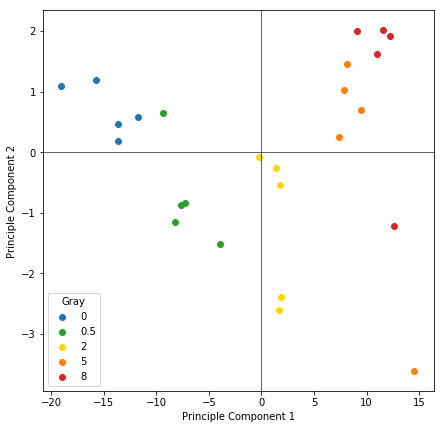

In [35]:
# Plot Loadings
Plt_Scores(X7sig0, Dose48, save = False, saveas = 'Scores_7sig.png')
#plt.savefig('Reduced_data_scores', bbox_inches = 'tight')

# Comparisons

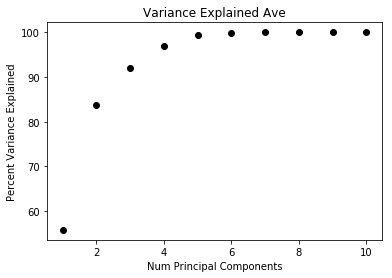

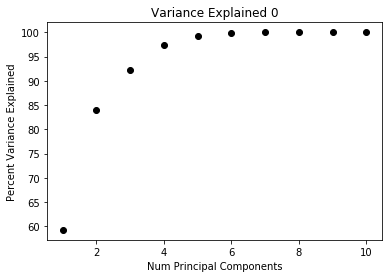

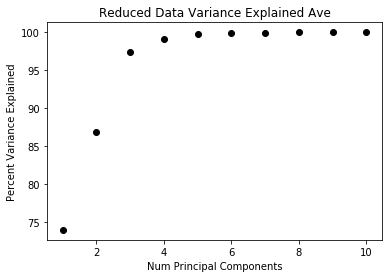

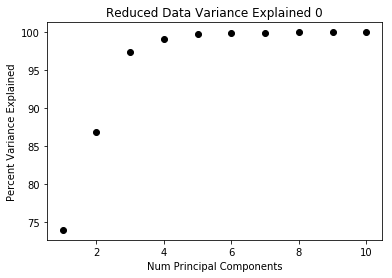

In [36]:
FullVarianceAve = Plt_Variance(X_avg, Dose48, 10, returnVariance = True, title = 'Variance Explained Ave');
FullVariance0 = Plt_Variance(X0, Dose48, 10, returnVariance = True, title = 'Variance Explained 0');
ReducedVarianceAve = Plt_Variance(X4sig0, Dose48, 10, returnVariance = True, title = 'Reduced Data Variance Explained Ave')
ReducedVariance0 = Plt_Variance(X4sig0, Dose48, 10, returnVariance = True, title = 'Reduced Data Variance Explained 0')

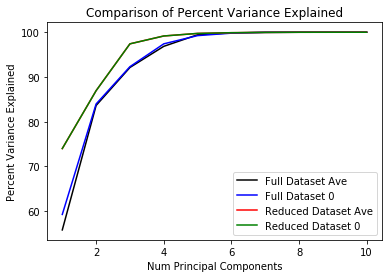

In [37]:
num_components = 10
plt.plot(range(1,num_components+1),FullVarianceAve, color = 'k', label = 'Full Dataset Ave')
plt.plot(range(1,num_components+1),FullVariance0, color = 'b', label = 'Full Dataset 0')
plt.plot(range(1,num_components+1),ReducedVarianceAve, color = 'r', label = 'Reduced Dataset Ave')
plt.plot(range(1,num_components+1),ReducedVariance0, color = 'g', label = 'Reduced Dataset 0')
plt.legend()
plt.title('Comparison of Percent Variance Explained')
plt.xlabel("Num Principal Components")
plt.ylabel("Percent Variance Explained");
#plt.savefig('Percent_Variance_Comparison', bbox_inches = 'tight')

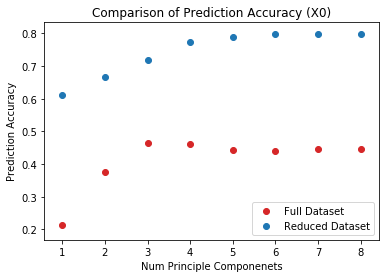

In [38]:
num_componenets = 8
plt.scatter(range(1, num_componenets+1), R2_array_Full, color = 'tab:red', label = 'Full Dataset')
plt.scatter(range(1, num_componenets+1), R2_array_Red, color = 'tab:blue', label = 'Reduced Dataset')
plt.legend(loc = 'lower right')
plt.title('Comparison of Prediction Accuracy (X0)') # currently with non-averaged
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');
#plt.savefig('Prediction_Accuracy_Comparsion_X0', bbox_inches = 'tight')

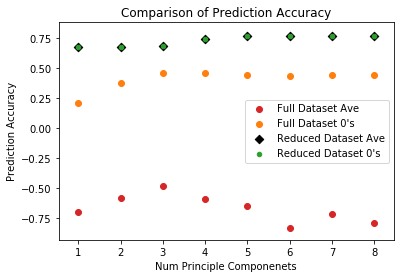

In [39]:
# Prediction Accuracy
R2_array_Full_Ave = np.load('R2_array_Full_Ave.npy')
R2_array_Full_X0 = np.load('R2_array_Full_X0.npy')

R2_array_Red_Ave = np.load('R2_array_Red_Ave.npy')
R2_array_Red_X0 = np.load('R2_array_Red_X0_8sig.npy')

plt.scatter(range(1, num_componenets+1), R2_array_Full_Ave, color = 'tab:red', label = 'Full Dataset Ave')
plt.scatter(range(1, num_componenets+1), R2_array_Full_X0, color = 'tab:orange', label = "Full Dataset 0's")
plt.scatter(range(1, num_componenets+1),R2_array_Red_Ave, color = 'k', marker = 'D', label = 'Reduced Dataset Ave')
plt.scatter(range(1, num_componenets+1), R2_array_Red_X0, color = 'tab:green',  s =  20, label = "Reduced Dataset 0's")
plt.legend()
plt.title('Comparison of Prediction Accuracy') # currently with non-averaged
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');

In [40]:
# Confirm t-test identifies same genes from averaged and zero missing data methods 
#(because any row with missing data is less likely to have significant differences across doses)
R2_array_Red_Ave == R2_array_Red_X0

array([ True,  True,  True,  True,  True,  True,  True,  True])